In [17]:
import pandas as pd 
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np


In [18]:
metricas = pd.read_csv('..\csv\metricasExpSP.csv')
metricas.head()

,Unnamed: 0,experimento,api,media,mediana,desvio_padrao,media_aparada,taxa_resposta,taxa_acerto
0,0,geoGoldSPexp1,MapBox,9.885009,0.264745,33.929581,5.545753,0.9750,0.4178
1,1,geoGoldSPexp1,Google,4.084331,0.136854,10.741415,2.554311,0.9988,0.5080
2,2,geoGoldSPexp1,TomTom,36.121177,0.108194,249.594126,3.940234,0.8548,0.4494
3,3,geoGoldSPexp1,OpenRouteService,8.016763,0.346648,16.978958,6.323177,0.9986,0.2894
4,4,geoGoldSPexp2,MapBox,13.914447,0.481439,36.798156,8.848430,0.9778,0.3704


In [19]:
substituicoes = {
    'geoGoldSPexp1': '1',
    'geoGoldSPexp2': '2',
    'geoGoldSPexp3': '3',
    'geoGoldSPexp4': '4',
    'geoGoldSPexp5': '5'
    }

# Substituir os valores conforme o dicionário
metricas['experimento'] = metricas['experimento'].map(substituicoes).fillna(metricas['experimento'])

# Salvar o arquivo com as substituições
metricas.to_csv('..\csv\metricas_atualizadoSP.csv', index=False)

metricas.head()


,Unnamed: 0,experimento,api,media,mediana,desvio_padrao,media_aparada,taxa_resposta,taxa_acerto
0,0,1,MapBox,9.885009,0.264745,33.929581,5.545753,0.9750,0.4178
1,1,1,Google,4.084331,0.136854,10.741415,2.554311,0.9988,0.5080
2,2,1,TomTom,36.121177,0.108194,249.594126,3.940234,0.8548,0.4494
3,3,1,OpenRouteService,8.016763,0.346648,16.978958,6.323177,0.9986,0.2894
4,4,2,MapBox,13.914447,0.481439,36.798156,8.848430,0.9778,0.3704


In [20]:
def determinar_falha(erro):
    if erro <= 0.15:
        return 0.0
    else:
        return 1.0

In [21]:
shapefile_path = 'https://github.com/rcpsilva/UncertaintyQuantificationForGeocodingServices/raw/main/PaperGeoinfo/results/SMunicipios_2022/SP_Municipios_2022.shp'
gdf = gpd.read_file(shapefile_path)
city_name = "São Paulo"  # Replace with the actual city name you want to plot
city_gdf = gdf[gdf['NM_MUN'] == city_name]

In [22]:
experimentos = pd.read_csv('..\csv\geoGoldSPexpTotal.csv')
experimentos.head()

,number,street,city,latGold,lonGold,id,geoapi_id,request_id,lat,long,accuracy,endereço,erro,experimento
0,45,JANE VANINE CAPOZI,SAO PAULO,-23.868805,-46.678967,2922600,Google,2922600,-23.870860,-46.676627,NaN,"JANE VANINE CAPOZI, 45, SAO PAULO, SP",0.329595,1
1,45,JANE VANINE CAPOZI,SAO PAULO,-23.868805,-46.678967,2922600,Here,2922600,-23.871140,-46.676530,1.0,"JANE VANINE CAPOZI, 45, SAO PAULO, SP",0.358461,1
2,45,JANE VANINE CAPOZI,SAO PAULO,-23.868805,-46.678967,2922600,OpenRouteService,2922600,-23.870566,-46.676880,0.8,"JANE VANINE CAPOZI, 45, SAO PAULO, SP",0.288491,1
3,45,JANE VANINE CAPOZI,SAO PAULO,-23.868805,-46.678967,2922600,MapBox,2922600,-23.870596,-46.676843,1.0,"JANE VANINE CAPOZI, 45, SAO PAULO, SP",0.293514,1
4,10,DOS LIRIOS,SAO PAULO,-23.638449,-46.447187,2922601,Google,2922601,-23.639972,-46.446220,NaN,"DOS LIRIOS, 10, SAO PAULO, SP",0.195449,1


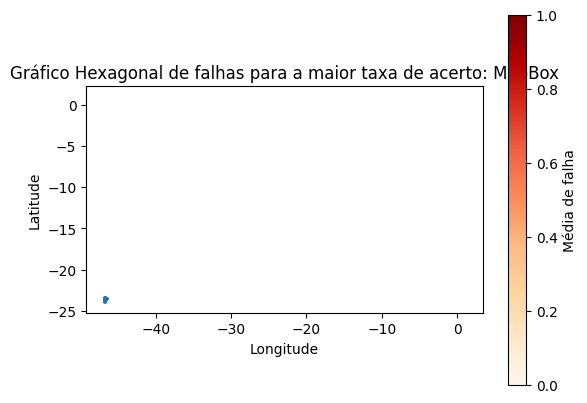

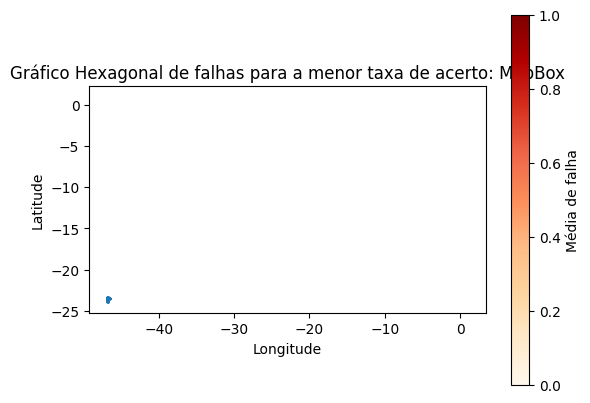

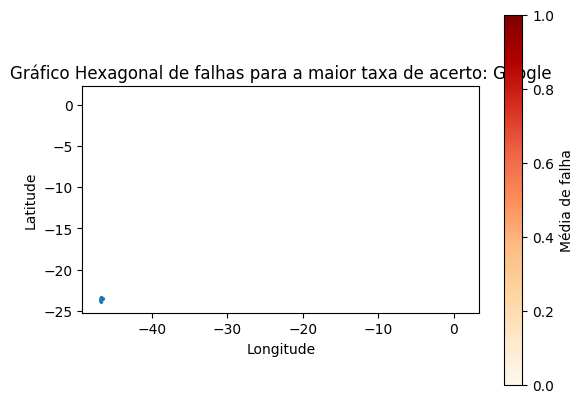

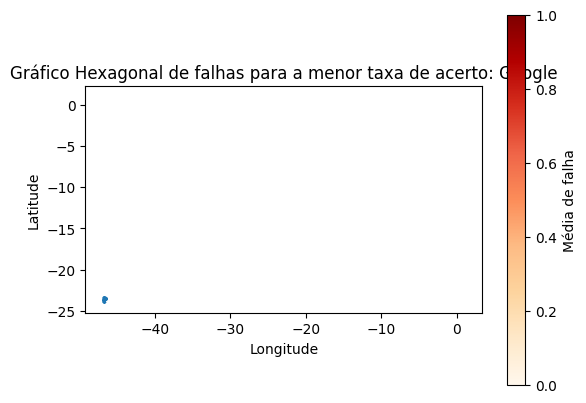

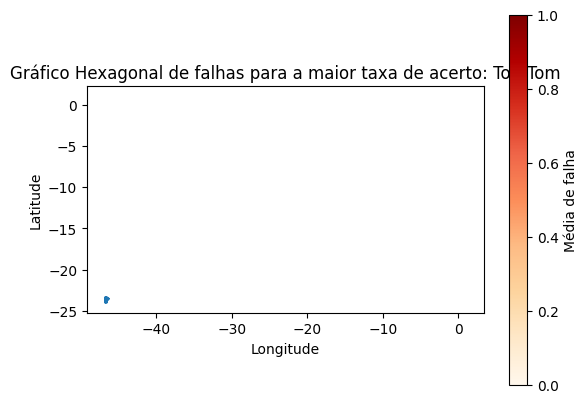

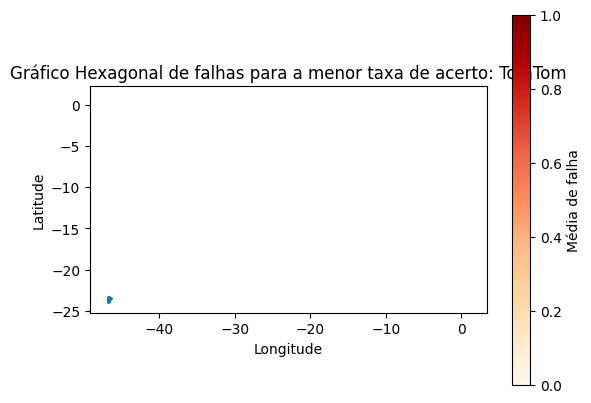

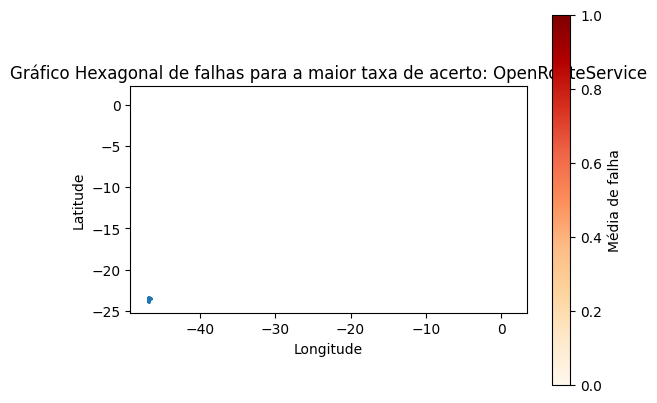

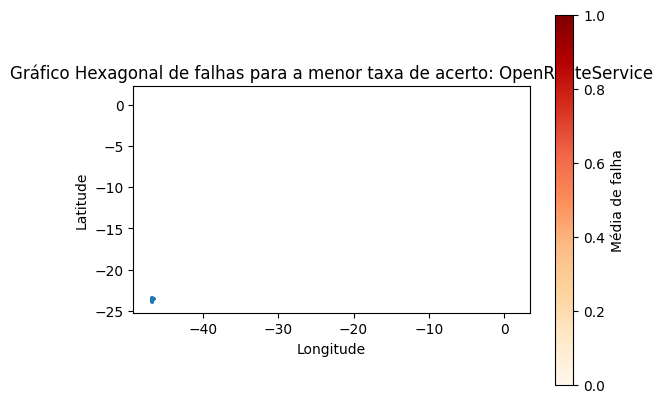

In [23]:
nome_apis = ['MapBox','Google', 'TomTom', 'OpenRouteService']
limite = 0.3
gridsize = 30

for api in nome_apis:
    filtro_api = metricas['api'] == api

    indice_max_taxa_acerto = metricas[filtro_api]['taxa_acerto'].idxmax()
    nome_arquivo_max = metricas.loc[indice_max_taxa_acerto, 'experimento']
    df_max = experimentos[experimentos['experimento'] == nome_arquivo_max]
    df_max = df_max[df_max['geoapi_id'] == api]
    #df = df[df['erro'] <= limite]
    falha =  df_max['erro'].apply(determinar_falha)
    df_max['falha'] = falha

    city_gdf.boundary.plot()
    hb = plt.hexbin(df_max['lonGold'], df_max['latGold'], C=df_max['falha'], gridsize=gridsize, cmap='OrRd',reduce_C_function=np.mean)
    cb = plt.colorbar()
    cb.set_label('Média de falha')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    #plt.title(f'Gráfico Hexagonal de falhas, com Erro Limitado em 300 metros: {api}')
    plt.title(f'Gráfico Hexagonal de falhas para a maior taxa de acerto: {api}')
    plt.clim(vmin=0, vmax=1)
    plt.show()

    
    indice_min_taxa_acerto = metricas[filtro_api]['taxa_acerto'].idxmin()
    nome_arquivo_min = metricas.loc[indice_min_taxa_acerto, 'experimento']
    df_min = experimentos[experimentos['experimento'] == nome_arquivo_min]
    df_min = df_min[df_min['geoapi_id'] == api]
    falha =  df_min['erro'].apply(determinar_falha)
    df_min['falha'] = falha
    
    city_gdf.boundary.plot()
    hb = plt.hexbin(df_min['lonGold'], df_min['latGold'], C=df_min['falha'], gridsize=gridsize, cmap='OrRd',reduce_C_function=np.mean)
    cb = plt.colorbar()
    cb.set_label('Média de falha')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    #plt.title(f'Gráfico Hexagonal de falhas, com Erro Limitado em 300 metros: {api}')
    plt.title(f'Gráfico Hexagonal de falhas para a menor taxa de acerto: {api}')
    plt.clim(vmin=0, vmax=1)
    plt.show()
    #print(df.head())
     